# Read data


In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

In [47]:
FILE_PATH = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/csv_files/EN2_STAR_MON_0100725706_20070516T060226_20071005T074409.csv'

In [48]:
df = pd.read_csv(FILE_PATH)
df.head()

,DATE,WHITEFLUX
0,2007-05-16 18:11:00.787644,75564.110
1,2007-05-16 18:19:32.829687,75574.570
2,2007-05-16 18:28:04.871730,75547.414
3,2007-05-16 18:36:36.913772,75688.330
4,2007-05-16 18:45:08.955815,75712.540


In [49]:
x = df.DATE.to_numpy()
y = df.WHITEFLUX.to_numpy()

# Filtering

## 1. Artificial borders

In [50]:
def artifical_borders(array, num):
  aux_pre = np.zeros(num)
  aux_pos = np.zeros(num)
  i = 0
  for i in range(num):
    aux_pre[i] = array[0]
    aux_pos[i] = array[-1]
  
  return np.concatenate((aux_pre, array, aux_pos)).ravel()

In [51]:
# Defining the numbers of points to be added

param = 70

In [52]:
y_artifical_borders = artifical_borders(y, param)

print("The original length was:", len(y), ", and now we have:", len(y_artifical_borders), "\nThe difference is:", (len(y_artifical_borders) - len(y) ))

The original length was: 23952 , and now we have: 24092 
The difference is: 140


## 2. Zero Padding

In [53]:
def padding(array):
  return np.append(array, np.zeros(len(array)))

In [54]:
y_padding = padding(y_artifical_borders)

print("The previous length was:", len(y_artifical_borders), ", and now we have:", len(y_padding), "\nThe difference is:", (len(y_padding) - len(y_artifical_borders) ))

The previous length was: 24092 , and now we have: 48184 
The difference is: 24092


## 3. Multiply by $(-1)^i$ 

In [55]:
def multiplying_by_minus_one_to_index(array):
  i = 0
  new_array = np.ones(len(array))

  for i in range(len(array)):
    new_array[i] = array[i] * ( (-1)**(i) )
  
  return new_array

In [56]:
y_multiplied = multiplying_by_minus_one_to_index(y_padding)

## 4. Fourier Transform

In [57]:
def fourier_transform(array):
  fft = np.fft.fft(array)
  
  return fft

In [58]:
y_fft = fourier_transform(y_multiplied)

In [59]:
y_fft

array([-16673.57200001+8.36371328e-09j,  47796.28989974+1.23804272e+04j,
         1859.81772268+2.77695961e+04j, ...,
        79054.83095289-8.48836152e+03j,   1859.81772268-2.77695961e+04j,
        47796.28989975-1.23804272e+04j])

## 5. Butterworth transfer function

In [60]:
cutoff_freq = 0.06 # Nyquist
order = 6

In [61]:
(n_time, columns) = df.shape
n_time

23952

In [62]:
d0 = cutoff_freq * n_time
xc = n_time

In [63]:
filter = np.zeros(int(2*(n_time + 2*param)))
len(filter)

48184

### Creating a filter array


In [64]:
for i in range(int(2.0*n_time + param)):
   filter[i] = 1.0/ (1.0+(abs(i-(xc-1.0))/d0)**(2.0*order))

In [65]:
filter

array([2.17787320e-15, 2.17896466e-15, 2.18005672e-15, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Apply filter

In [66]:
y_butter = filter * y_fft
y_butter

array([-3.63129257e-11+1.82151070e-23j,  1.04146427e-10+2.69765134e-11j,
        4.05450812e-12+6.05392946e-11j, ...,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j])

## 6. Inverse Fourier Transform

In [67]:
def inverse_fourier_transform(array):
  ifft = np.fft.ifft(array)

  return ifft

In [68]:
y_ifft = np.real(inverse_fourier_transform(y_butter))
y_ifft

array([ 40061.84475311, -44591.25236119,  49031.44367049, ...,
       -26532.82106322,  30973.01789152, -35502.42816796])

## 7. Removing Zero Padding

In [69]:
y1 = y_ifft[:int(len(y_ifft)/2)]

print("The before length was:", len(y_ifft), ", and now we have:", len(y1))

The before length was: 48184 , and now we have: 24092


In [70]:
y1

array([ 40061.84475311, -44591.25236119,  49031.44367049, ...,
       -49487.43036895,  45005.9389584 , -40434.40507966])

## 8. Cuting artificial borders

In [71]:
param = param # equals 70, but we might change that value

In [72]:
y2 = np.delete(y1, np.s_[:param])
y3 = np.delete(y2, np.s_[-param:])

y3

array([ 75486.84813925, -75500.92753975,  75516.38608975, ...,
       -76185.28295457,  76172.25850588, -76160.68077399])

## 9. Re-multiplying data by $(-1)^{i}$

In [73]:
y_plot = multiplying_by_minus_one_to_index(y3)
y_plot

array([75486.84813925, 75500.92753975, 75516.38608975, ...,
       76185.28295457, 76172.25850588, 76160.68077399])

## 10. Plotting results

In [88]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                           mode='lines',
                           name='Original Light Curve'))

fig.add_trace(go.Scatter(x=x, y=y_plot,
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Light Curve before and after the Butterworth filter',
                   xaxis_title='Date',
                   yaxis_title='Whiteflux')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

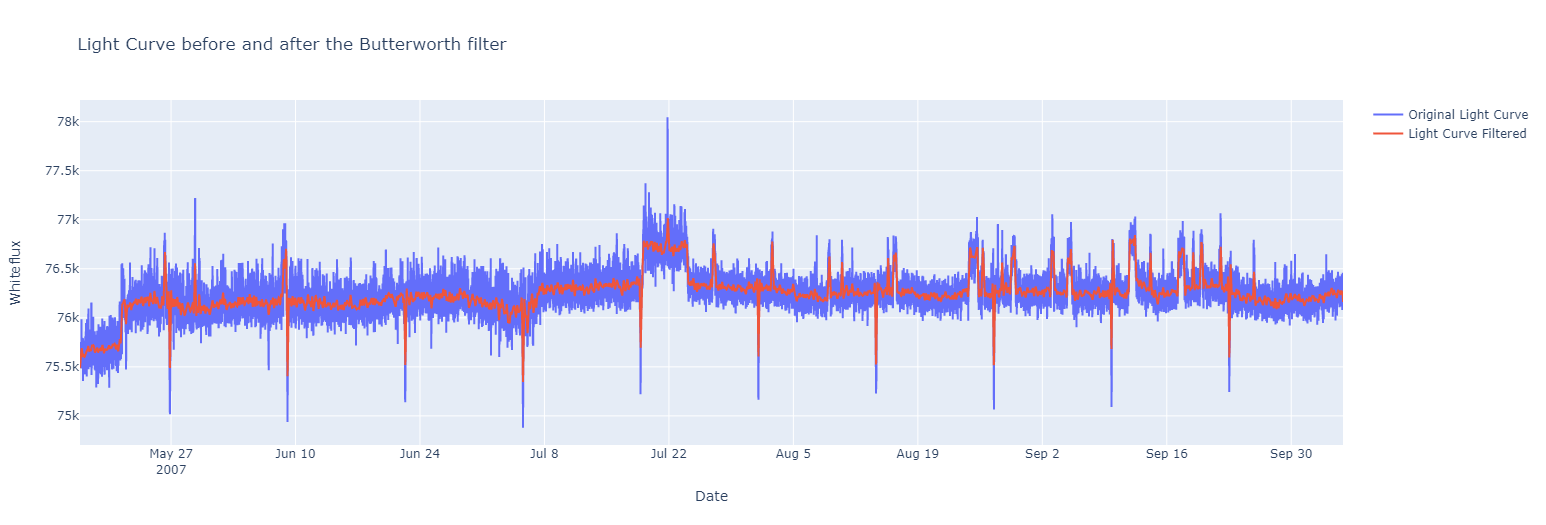

# Plotting test

In [30]:
from tools import viz

In [124]:
viz.view_lightcurve(x=x, y=y_plot)

In [86]:
from bokeh.plotting import figure, output_file, show

df['DATE'] = pd.to_datetime(df['DATE'])

# create a new plot with a datetime axis type
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

p.line(df['DATE'], df['WHITEFLUX'], color='blue', alpha=0.5)
p.line(df['DATE'], y_plot, color='red')

show(p)

In [116]:
from bokeh.plotting import figure, output_file, show

def view_lightcurve(x_data, y_data):

  if (str(type(x_data[0])) != "<class 'pandas._libs.tslibs.timestamps.Timestamp'>"):
    x_data = pd.DataFrame(x_data)
    x_data = pd.to_datetime(x_data)

  p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

  p.line(x_data, y_data, color='blue')

  show(p)

In [123]:
view_lightcurve(df.DATE, y)